In [1]:
import numpy
from matplotlib import pyplot
import matplotlib
import os
import scipy.optimize

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
basedir = "markov_data"

In [3]:
data = {}

for file in sorted(os.listdir(basedir)):
    if file.endswith(".npz"):
        arr = numpy.load(os.path.join(basedir, file))
        L = arr["L"][()]
        if L not in data:
            data[L] = []
        data[L].append({key: arr[key] for key in arr._files})

# Focus

In [4]:
L = 16
ell = 16

# Prob dist

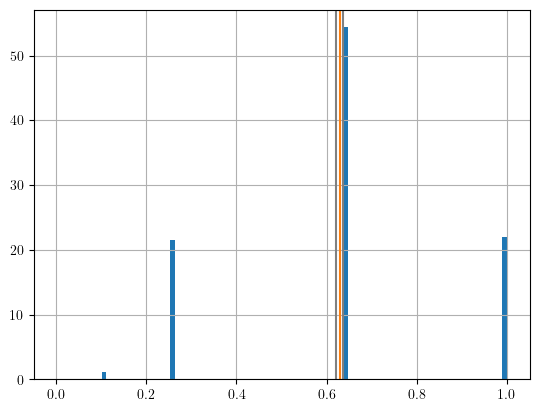

In [5]:
tp = data[L][0]["all_transition_probs"]

pyplot.hist(tp[:,ell*ell,0], bins=numpy.linspace(0,1,100), density=True)

ylims = pyplot.ylim()

xmean = tp[:,ell*ell,0].mean()
xmeanstd = tp[:,ell*ell,0].std() / numpy.sqrt(tp.shape[0])
pyplot.plot([xmean, xmean], [-1e6,1e6])
pyplot.plot([xmean-xmeanstd, xmean-xmeanstd], [-1e6,1e6], c='gray')
pyplot.plot([xmean+xmeanstd, xmean+xmeanstd], [-1e6,1e6], c='gray')
pyplot.ylim(ylims)
pyplot.grid()
pyplot.show()

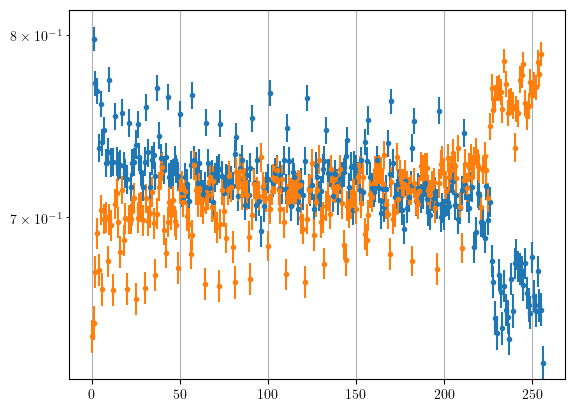

In [6]:
ks = []
pups = []
pupstds = []
pdowns = []
pdownstds = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    if "all_transition_probs" in d:
        k = d["k"][()]
        tp = d["all_transition_probs"]
        means = tp.mean(axis=0)
        stderrs = tp.std(axis=0) / numpy.sqrt(tp.shape[0])
        pyplot.errorbar(numpy.arange(means.shape[0]), means[:,0], yerr=stderrs[:,0], label=f"{k:.3f}", fmt='.')
        pyplot.errorbar(numpy.arange(means.shape[0]), means[:,1], yerr=stderrs[:,1], label=f"{k:.3f}", fmt='.')
        break
pyplot.yscale('log')
pyplot.grid()
pyplot.show()

/tmp/ipykernel_30684/2293703987.py:18: RuntimeWarning: invalid value encountered in divide
  rel_std = stderrs / means


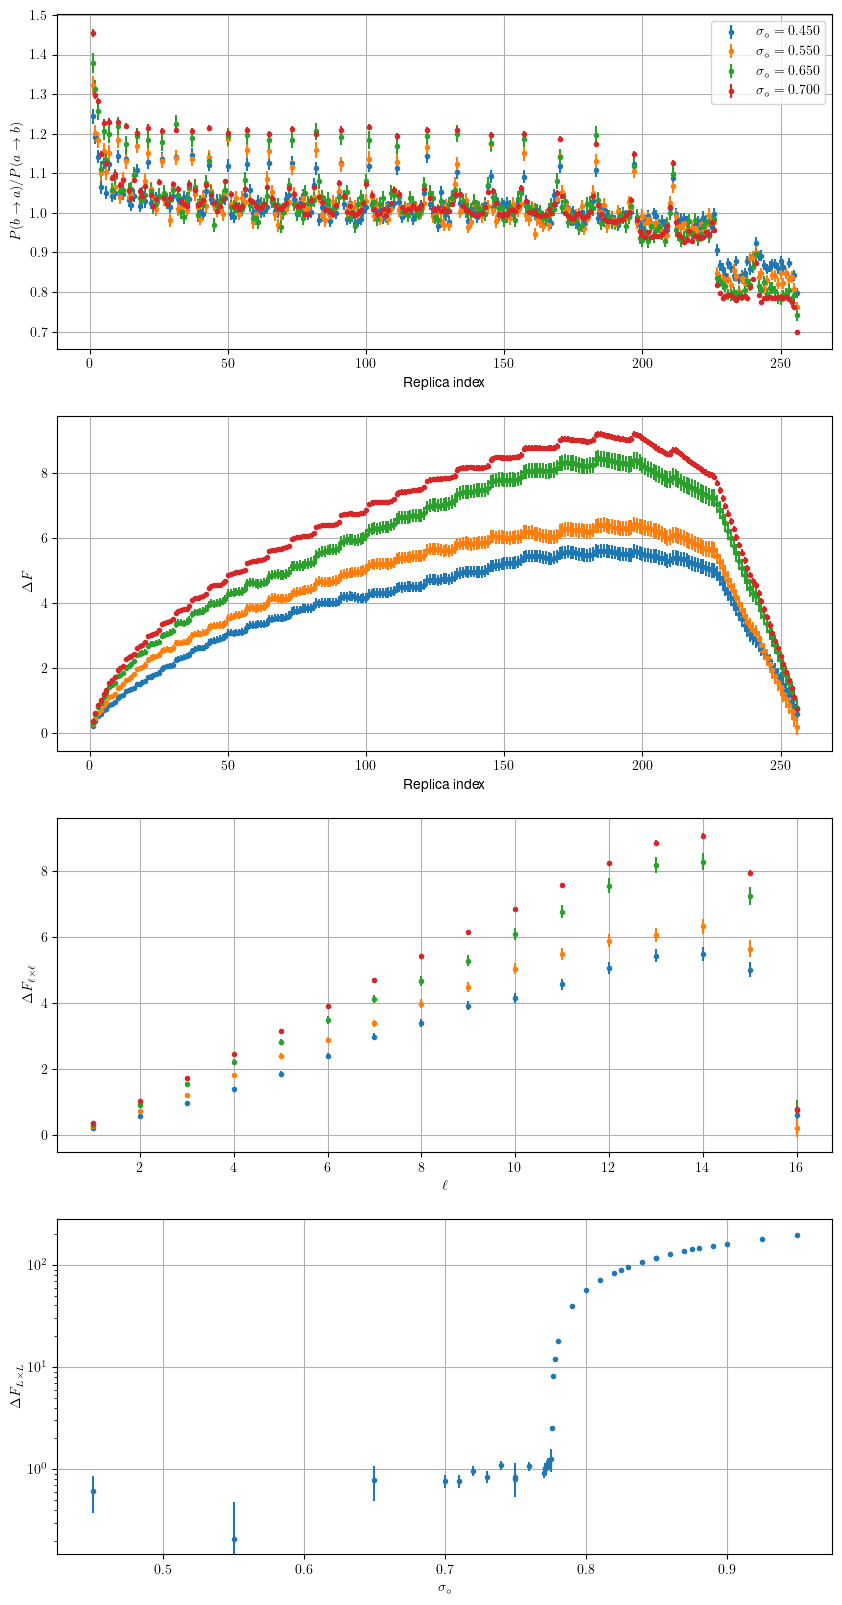

In [7]:
def near(x, xs, tol=1e-3):
    return any(abs(x - xx)<tol for xx in xs)

fig, axs = pyplot.subplots(4, figsize=(10, 20))

plot_ks = [0.45, 0.55, 0.65, 0.7]

ks = []
last_fe = []
last_fe_std = []

for d in sorted(data[L], key=lambda d: d["k"][()]):
    if "all_transition_probs" in d:
        k = d["k"][()]
        tp = d["all_transition_probs"]
        means = tp.mean(axis=0)
        stderrs = tp.std(axis=0) / numpy.sqrt(tp.shape[0])
        rel_std = stderrs / means

        rel_means = means[1:,0] / means[:-1,1]
        rel_stderrs = numpy.sqrt(rel_std[1:,0]**2 + rel_std[:-1,1]**2)
        
        if near(k, plot_ks):
            axs[0].errorbar(numpy.arange(1, means.shape[0]), rel_means, yerr=rel_stderrs * rel_means, fmt='.', label=fr'$\sigma_\circ = {k:.3f}$')
        
        cumulative_log_rel_means = numpy.cumsum(numpy.log(rel_means))
        cumulative_log_rel_rel_errs = numpy.sqrt(numpy.cumsum(rel_std[1:,0]**2) + numpy.cumsum(rel_std[:-1,1]**2))

        # Relative errors become absolute with a log
        # log((1 +/- d)x) = log(x) +/- d
        stderr = cumulative_log_rel_rel_errs
        
        if near(k, plot_ks):
            axs[1].errorbar(numpy.arange(1, means.shape[0]), cumulative_log_rel_means, yerr=stderr, fmt='.', label=fr'$\sigma_\circ = {k:.3f}$')

        sqr_means = [cumulative_log_rel_means[i*i - 1] for i in range(1, ell+1)]
        sqr_stderrs = [stderr[i*i - 1] for i in range(1, ell+1)]
        
        if near(k, plot_ks):
            axs[2].errorbar(numpy.arange(1, L+1), sqr_means, yerr=sqr_stderrs, fmt='.', label=fr'$\sigma_\circ = {k:.3f}$')

        ks.append(k)
        last_fe.append(sqr_means[-1])
        last_fe_std.append(sqr_stderrs[-1])
axs[3].errorbar(ks, last_fe, yerr=last_fe_std, fmt='.')

axs[0].legend()
axs[0].set_ylabel(r"$P(b\rightarrow a) / P(a \rightarrow b)$")
axs[0].set_xlabel(r"Replica index")
axs[0].grid()

axs[1].set_ylabel(r"$\Delta F$")
axs[1].set_xlabel(r"Replica index")
axs[1].grid()

axs[2].set_ylabel(r"$\Delta F_{\ell \times \ell}$")
axs[2].set_xlabel(r"$\ell$")
axs[2].grid()

axs[3].set_ylabel(r"$\Delta F_{L \times L}$")
axs[3].set_xlabel(r"$\sigma_{\circ}$")
axs[3].grid()
axs[3].set_yscale('log')

pyplot.show()

# Free Energies

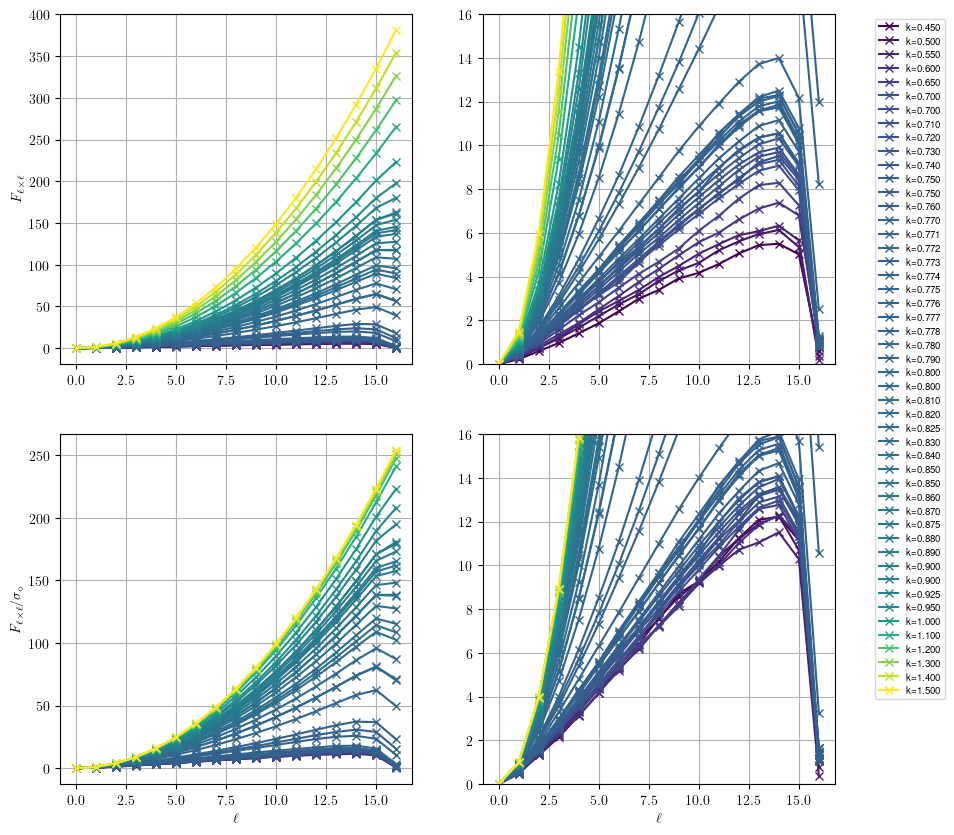

In [8]:
kmin = min(d["k"][()] for d in data[L])
kmax = max(d["k"][()] for d in data[L])
norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, axs = pyplot.subplots(2,2, figsize=(10,10))

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.2f}", c=cmap(k))
axs[0,0].grid()
axs[0,0].set_ylabel(r"$F_{\ell \times \ell}$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,0].grid()
axs[1,0].set_xlabel(r"$\ell$")
axs[1,0].set_ylabel(r"$F_{\ell \times \ell}/\sigma_\circ$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[0,1].grid()
axs[0,1].set_ylim([0,16])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,1].grid()
axs[1,1].set_ylim([0,16])
axs[1,1].set_xlabel(r"$\ell$")

axs[0,1].legend(fontsize=7, bbox_to_anchor=(1.1,1.0))

pyplot.savefig("free_energy_flows.png")
pyplot.show()

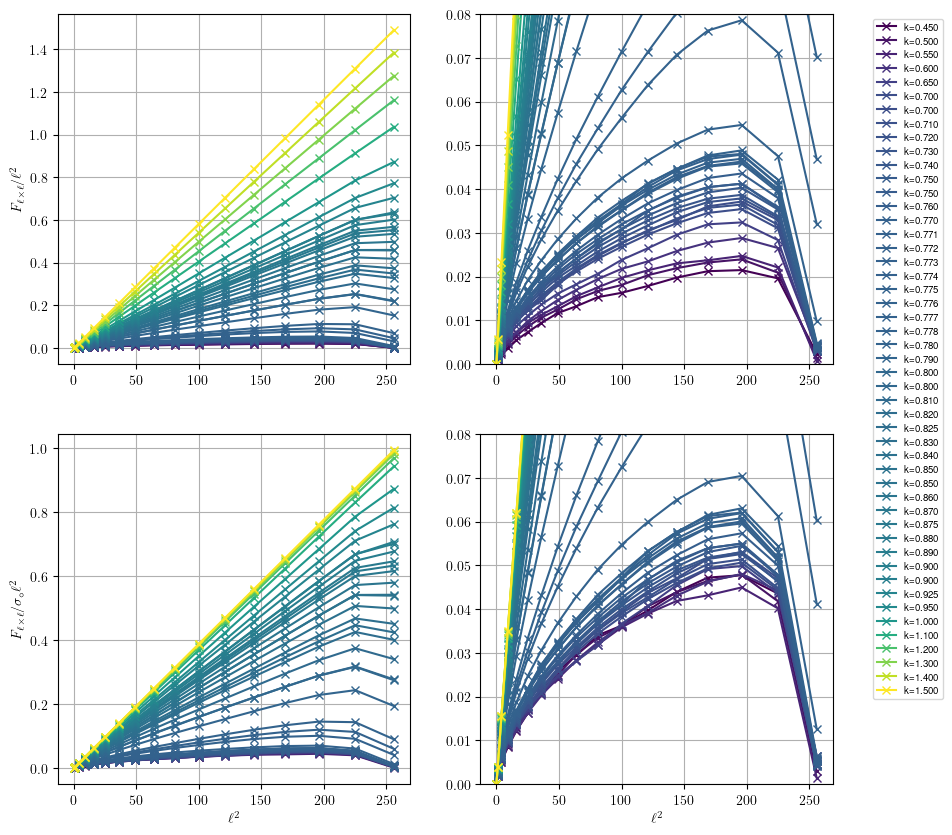

In [9]:
kmin = min(d["k"][()] for d in data[L])
kmax = max(d["k"][()] for d in data[L])
norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, axs = pyplot.subplots(2,2, figsize=(10,10))
xs = numpy.arange(L+1)**2
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot(xs, [d["free_energy"][i*i]/(L**2) for i in range(L+1)], "x-", label=f"k={k:.2f}", c=cmap(k))
axs[0,0].grid()
axs[0,0].set_ylabel(r"$F_{\ell \times \ell}/\ell^2$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot(xs, [d["free_energy"][i*i] / (k * L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,0].grid()
axs[1,0].set_xlabel(r"$\ell^2$")
axs[1,0].set_ylabel(r"$F_{\ell \times \ell}/\sigma_\circ \ell^2$")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot(xs, [d["free_energy"][i*i]/(L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[0,1].grid()
axs[0,1].set_ylim([0,0.08])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot(xs, [d["free_energy"][i*i] / (k * L**2) for i in range(L+1)], "x-", label=f"k={k:.3f}", c=cmap(k))
axs[1,1].grid()
axs[1,1].set_ylim([0,0.08])
axs[1,1].set_xlabel("$\ell^2$")

axs[0,1].legend(fontsize=7, bbox_to_anchor=(1.1,1.0))

pyplot.savefig("free_energy_flows_sqr.png")
pyplot.show()

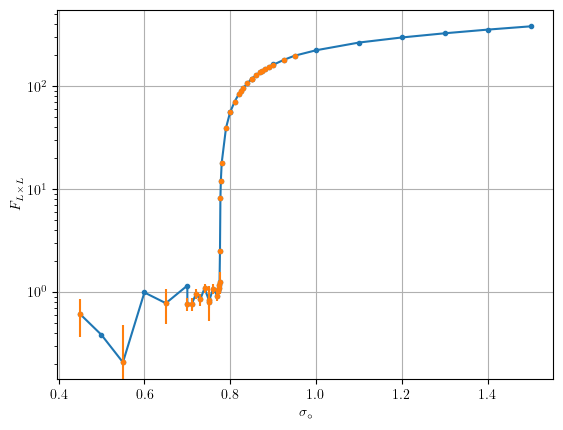

In [10]:
all_dat = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = d["free_energy"][L*L]
    all_dat.append((k,lf))
pyplot.plot(*zip(*all_dat), '.-')

pyplot.errorbar(ks, last_fe, yerr=last_fe_std, fmt='.')

pyplot.yscale('log')
pyplot.ylabel(r"$F_{L \times L}$")
pyplot.xlabel(r"$\sigma_\circ$") 
pyplot.grid()
pyplot.show()

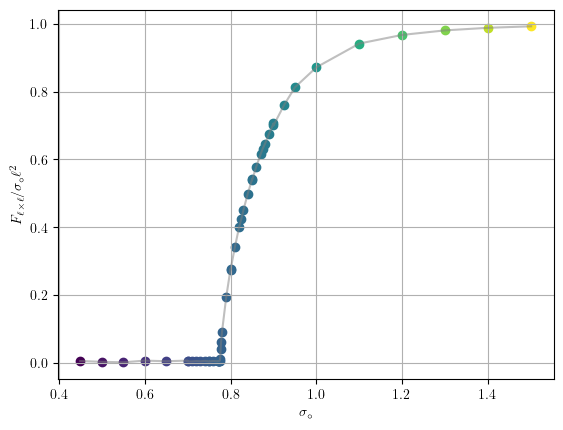

In [11]:
all_dat = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = d["free_energy"][L*L]/(k*L*L)
    all_dat.append((k,lf))
pyplot.plot(*zip(*all_dat), c='gray', alpha=0.5)

for k, lf in all_dat:
    pyplot.scatter([k], [lf], c=[cmap(k)])

pyplot.ylabel(r"$F_{\ell \times \ell} / \sigma_\circ \ell^2$")
pyplot.xlabel(r"$\sigma_\circ$") 
pyplot.grid()
pyplot.savefig("cost_for_plane.png")
pyplot.show()

# Derivative stuff

In [12]:
all_dat = []

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    lf = [d["free_energy"][i*i] for i in range(L + 1)]
    gradlf = numpy.gradient(lf, edge_order=2)
    grad2lf = numpy.gradient(gradlf, edge_order=2)
    all_dat.append((k,lf, gradlf, grad2lf))

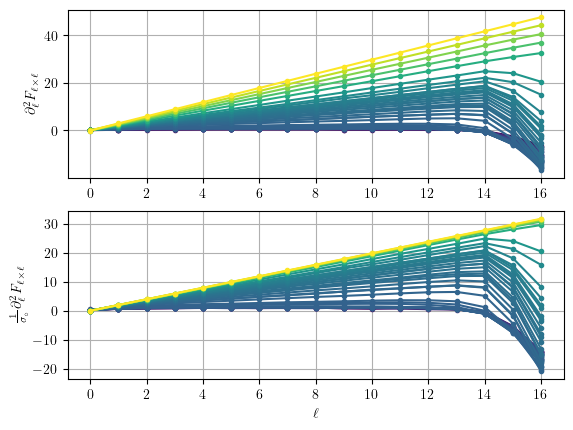

In [13]:
fig, axs = pyplot.subplots(2)

for (k, _, gradlf, _) in all_dat:
    axs[0].plot(gradlf, '.-', c=cmap(k))
axs[0].grid()
# axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, gradlf, _) in all_dat:
    axs[1].plot(gradlf/k, '.-', c=cmap(k))
axs[1].grid()
# axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.savefig("first_derive_across_ell.png")
pyplot.show()

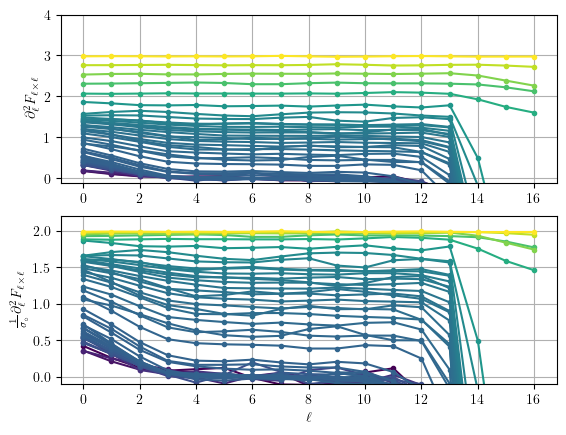

In [14]:
fig, axs = pyplot.subplots(2)

for (k, _, _, grad2lf) in all_dat:
    axs[0].plot(grad2lf, '.-', c=cmap(k))
axs[0].grid()
axs[0].set_ylim([-0.1,4])
axs[0].set_ylabel(r"$\partial_{\ell}^2 F_{\ell \times \ell}$")
for (k, _, _, grad2lf) in all_dat:
    axs[1].plot(grad2lf/k, '.-', c=cmap(k))
axs[1].grid()
axs[1].set_ylim([-0.1,2.2])
axs[1].set_ylabel(r"$\frac{1}{\sigma_\circ} \partial_{\ell}^2 F_{\ell \times \ell}$")
axs[1].set_xlabel(r"$\ell$")

pyplot.savefig("second_derive_across_ell.png")
pyplot.show()

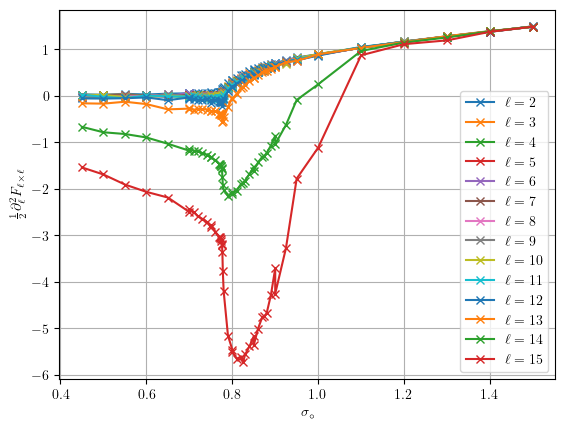

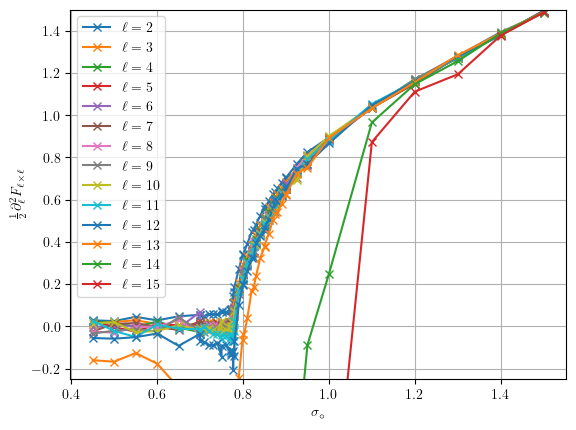

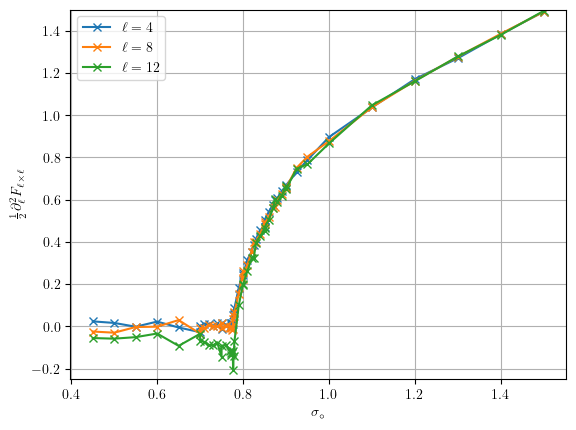

In [15]:
for i in range(2,L):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.show()

for i in range(2,L):
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,1.5))
pyplot.show()


for i in [L//4,L//2,(3*L)//4]:
    plot_dat = []
    for (k, _, _, grad2lf) in all_dat:
        plot_dat.append((k, grad2lf[i]/2))
    pyplot.plot(*zip(*plot_dat), 'x-', label=rf"$\ell={i}$")
pyplot.grid()
pyplot.legend()
pyplot.xlabel(r"$\sigma_\circ$")
pyplot.ylabel(r"$\frac{1}{2} \partial_{\ell}^2 F_{\ell \times \ell}$")
pyplot.ylim((-0.25,1.5))
pyplot.savefig("second_deriv.png")
pyplot.show()

# Fitted curves seem very sensitive to fit region

In [51]:
# fit_range_low, fit_range_high = (L//4, (3*L)//2)
fit_range_low, fit_range_high = (2, 11)

def lqc(x, a, b, c):
    return c + b*x + a*x*x

def lq(x, a, b):
    return b*x + a*x*x

ks = []
fits = []
fits_std = []
fitsz = []
fitsz_std = []
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    ls = numpy.arange(0,L+1)
    f = numpy.array([d["free_energy"][i*i] for i in range(L+1)])
    # fit = numpy.polyfit(ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 2)
    
    (a,b,c), pcov = scipy.optimize.curve_fit(lqc, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 
                                           p0=[0.05,0.05, 0.05])    
    perr = numpy.sqrt(numpy.diag(pcov))
    ks.append(k)
    fits.append([a,b,c])
    fits_std.append(perr)


    (a,b), pcov = scipy.optimize.curve_fit(lq, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 
                                           p0=[0.05,0.05])
    perr = numpy.sqrt(numpy.diag(pcov))
    fitsz.append([a,b,0])
    fitsz_std.append(perr)

ks = numpy.array(ks)
fits = numpy.array(fits)
fits_std = numpy.array(fits_std)
fitsz = numpy.array(fitsz)
fitsz_std = numpy.array(fitsz_std)

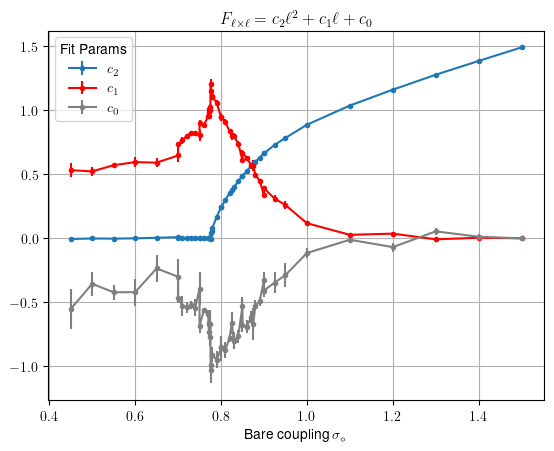

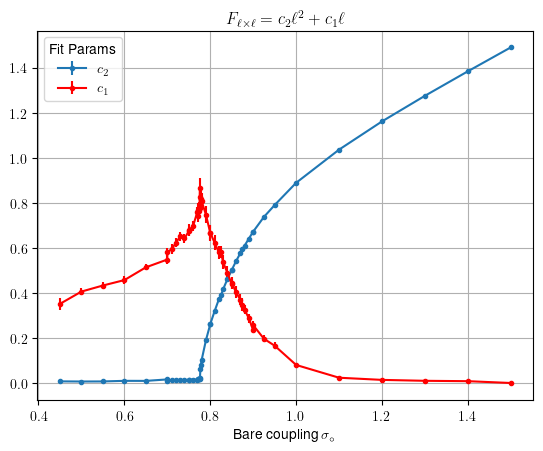

In [52]:
pyplot.errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label="$c_2 $")
pyplot.errorbar(ks, fits[:,1], yerr=fits_std[:,1], fmt= '.-', c='r', label="$ c_1 $")
pyplot.errorbar(ks, fits[:,2], yerr=fits_std[:,2], fmt= '.-', c='gray', label="$ c_0 $")

pyplot.title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell + c_0$")
pyplot.grid()
pyplot.legend(title="Fit Params")
pyplot.xlabel(r"Bare coupling $\sigma_{\circ}$")
pyplot.show()

pyplot.errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label="$c_2 $")
pyplot.errorbar(ks, fitsz[:,1], yerr=fitsz_std[:,1], fmt= '.-', c='r', label="$ c_1 $")
pyplot.title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell$")
pyplot.grid()
pyplot.legend(title="Fit Params")
pyplot.xlabel(r"Bare coupling $\sigma_{\circ}$")
pyplot.show()

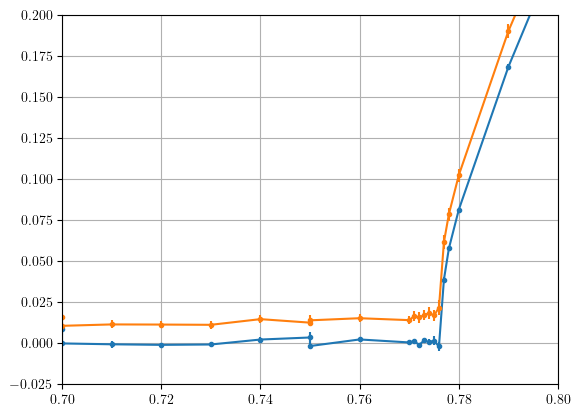

In [53]:
pyplot.errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label="$c_2$")
pyplot.errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label="$c_2$")
pyplot.grid()
pyplot.xlim([0.7,0.8])
pyplot.ylim([-0.025,0.2])
pyplot.show()

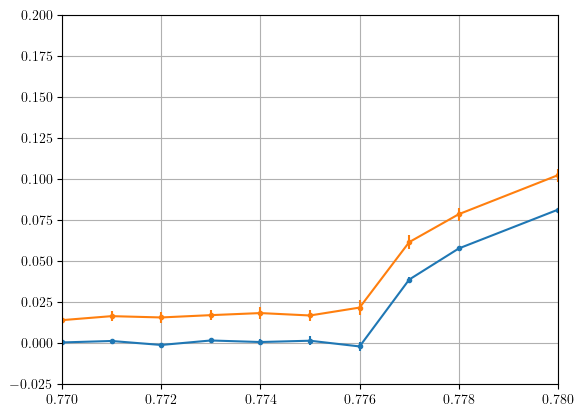

In [55]:
pyplot.errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label="$c_2$")
pyplot.errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label="$c_2$")
pyplot.grid()
pyplot.xlim([0.77,0.78])
pyplot.ylim([-0.025,0.2])
pyplot.show()